Datos:

- regiones y comunas http://www.subdere.gov.cl/documentacion/c%C3%B3digos-%C3%BAnicos-territoriales-actualizados-al-06-de-septiembre-2018

In [3]:
import pandas as pd
import seaborn as sn
import scipy
import numpy as np
import plotly.express as px
from statsmodels.distributions.empirical_distribution import ECDF

In [4]:
ls ../datos/

esi-2019.csv                guia-personas-esi-2019.pdf
estudio_fundacion_sol.pdf   region_comuna.csv


In [5]:
path = "../datos/"
esi = pd.read_csv(path+"esi-2019.csv", sep=';', encoding='latin')
region_comuna = pd.read_csv(path+"region_comuna.csv", sep=';')

esi = pd.merge(esi, region_comuna, left_on='r_p_c', right_on='Código Comuna 2018', how='left')
esi.drop(['region'], axis=1, inplace=True)

columns_map = {
    'id_identificacion': 'id_hogar',
    'idrph': 'id_persona',
    'tipo': 'tipo_estrato',
    't_muestra': 'tipo_muestra',
    'd1_monto': 'sueldo_neto',
    'Nombre Región': 'region',
    'Nombre Provincia': 'provincia',
    'Nombre Comuna': 'comuna',
    'b1': 'grupo_ocupacion',
    'cise': 'categoria_empleo',
    'b8': 'tiene_contrato',
    'b12': 'est_subcontratado',
    'b13_rev4cl_cae': 'rubro',
    'c1': 'tipo_jornada',
}

esi = esi.rename(columns=columns_map)

values_map = {
    'parentesco': {
        1: 'Jefe de hogar',
        2: 'Cónyuge',
        3: 'Conviviente',
        4: 'Hijo(a) / Hijastro(a)',
        5: 'Yerno / Nuera',
        6: 'Nieto(a)',
        7: 'Hermano(a) / Cuñado(a)',
        8: 'Padres / Suegros',
        9: 'Otro pariente',
        10: 'No pariente',
        11: 'Servicio doméstico',
        12: 'Fuera del hogar',
        13: 'Fallecido',
    }
    ,
    
    'nivel': {
        0: 'Nunca estudió',
        1: 'Sala cuna',
        2: 'Kínder',
        3: 'Básica o primaria 4 Media común',
        5: 'Media técnico profesional 6 Humanidades',
        7: 'Centro formación técnica 8 Instituto profesional',
        9: 'Universitario 10 Postítulo',
        11: 'Magíster',
        12: 'Doctorado',
        14: 'Normalista',
        99: 'Nivel ignorado',
        999: 'Nivel ignorado',
    }
    ,
    
    'tipo_estrato': {
        1: 'Ciudad',
        2: 'Resto area urbana',
        3: 'Rural'
    }
    ,
    
    'sexo': {
        1: 'Hombre',
        2: 'Mujer'
    }
    ,
    
    'termino_nivel': {
        1: "Si",
        2: "No"
    }
    ,
    
    'cine': {
        1: "Nunca estudió",
        2: "Educación preescolar",
        3: 'Educación primaria (nivel 1)',
        4: 'Educación primaria (nivel 2)',
        5: 'Educación secundaria',
        6: 'Educación técnica',
        7: 'Educación universitaria',
        8: 'Postítulo y maestría',
        9: 'Doctorado',
        999: None
    }
    ,
    
    'est_conyugal': {
        0: None,
        1: "Casade",
        2: "Coviviente",
        3: "Soltere",
        4: "Viude",
        5: "Separade",
        6: "Divorciade"
    }
    ,
    
    #'nacionalidad': {}
    
   
}


for variable, mapping in values_map.items():
    esi[variable] = esi[variable].map(mapping)
    
def procesar_monto(x):
    try:
        if ',' in x:
            x = x.replace(',', '.')
        return float(x)
    except:
        return x

esi['sueldo_neto'] = esi['sueldo_neto'].apply(procesar_monto)

In [8]:
esi.nacionalidad.value_counts()

0        93321
20052      765
20042      548
20010      495
20027      320
20014      306
20004       96
20018       61
20016       37
20044       33
20011       30
20041       22
40014       22
20020       19
20051       18
20017       13
20037       13
40025       12
40002       11
20019       10
40017        9
30011        7
30034        7
20012        6
10001        6
30044        5
30041        5
40042        5
30013        4
10005        3
40022        2
40041        2
50002        2
40004        2
30039        2
20028        2
40036        2
20024        2
10002        1
10050        1
30051        1
10030        1
10023        1
40021        1
10010        1
40020        1
40043        1
30021        1
20034        1
30035        1
40010        1
10003        1
40033        1
Name: nacionalidad, dtype: int64

In [13]:
!pwd

/Users/pipe/Documents/repos/esi2019-modelos/notebooks


In [11]:
sueldo_col_name = 'sueldo_neto'

cdf_function = ECDF(esi[sueldo_col_name].dropna().values)
sueldo_range = np.linspace(0, esi[sueldo_col_name].max())
px.line(x=sueldo_range, y=100*cdf_function(sueldo_range))

<AxesSubplot:>

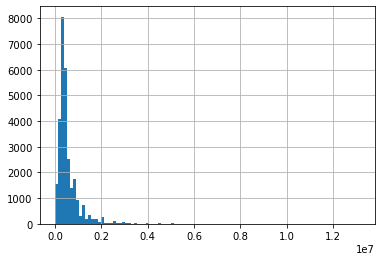

In [12]:
esi['sueldo_neto'].hist(bins=100)

In [89]:
def get_cdf(x):
    cdf_function = ECDF(x)
    return 100*cdf_function(sueldo_range)

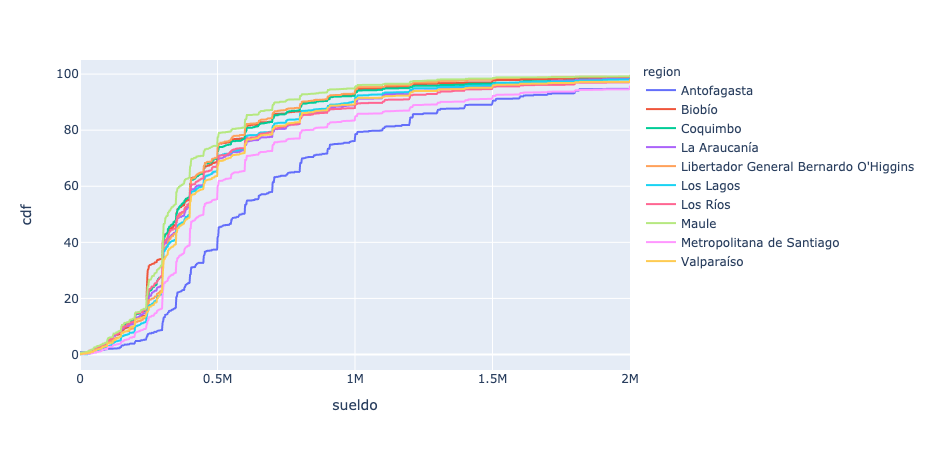

In [102]:
sueldo_col_name = 'sueldo_neto'
groupby_col = 'region'
max_n_groups = 10
#max_sueldo = esi[sueldo_col_name].max()
max_sueldo = 2_000_000

sueldo_range = np.linspace(0, max_sueldo, 1000)

nro_datos_grupo = esi.dropna(subset=[sueldo_col_name])[groupby_col].value_counts()
grupos_a_usar = list(nro_datos_grupo.index[:max_n_groups].values)

restriccion = esi.dropna(subset=[sueldo_col_name])[groupby_col].isin(grupos_a_usar)
cdf_dict = esi.dropna(subset=[sueldo_col_name]).loc[restriccion].groupby(groupby_col)[sueldo_col_name].apply(get_cdf).to_dict()
cdf_df = pd.DataFrame(cdf_dict, index=sueldo_range).reset_index().rename(columns={'index': 'sueldo'})
cdf_df = cdf_df.melt(id_vars=['sueldo'], var_name=groupby_col, value_name='cdf')
px.line(cdf_df, x='sueldo', y='cdf', color=groupby_col)

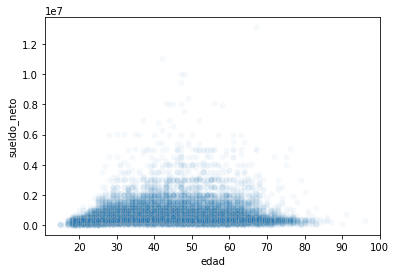

In [143]:
sn.scatterplot(data=esi, x='edad', y='sueldo_neto', alpha=0.04)

In [105]:
esi.nivel

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
96235    NaN
96236    NaN
96237    NaN
96238    NaN
96239    NaN
Name: nivel, Length: 96240, dtype: object

In [111]:
esi.groupby(['nivel']).sueldo_neto.mean().sort_values(ascending=False).to_frame().reset_index().head(20)

,nivel,sueldo_neto
0,Doctorado,2.093541e+06
1,Magíster,1.764538e+06
2,Universitario 10 Postítulo,9.257243e+05
3,Centro formación técnica 8 Instituto profesional,5.323213e+05
4,Normalista,4.611685e+05
5,Media técnico profesional 6 Humanidades,4.584646e+05
6,Nivel ignorado,3.738673e+05
7,Básica o primaria 4 Media común,3.152666e+05
8,Nunca estudió,2.722647e+05
9,Kínder,2.571856e+05


In [140]:
esi.groupby(['parentesco']).sueldo_neto.median().sort_values(ascending=False).to_frame().reset_index().head(20)

,parentesco,sueldo_neto
0,Servicio doméstico,436759.719380
1,Jefe de hogar,430000.000000
2,Cónyuge,400000.000000
3,Yerno / Nuera,399690.970546
4,Conviviente,399690.970546
5,Hijo(a) / Hijastro(a),352864.659456
6,No pariente,349729.599227
7,Hermano(a) / Cuñado(a),349729.599227
8,Otro pariente,320000.000000
9,Padres / Suegros,302455.422391


In [124]:
esi.groupby(['region', 'comuna']).sueldo_neto.median().sort_values(ascending=False).to_frame().reset_index().head(20)

,region,comuna,sueldo_neto
0,Metropolitana de Santiago,Vitacura,1.199536e+06
1,Metropolitana de Santiago,Providencia,1.199073e+06
2,Metropolitana de Santiago,Las Condes,1.008185e+06
3,Metropolitana de Santiago,La Reina,1.000000e+06
4,Metropolitana de Santiago,Ñuñoa,8.946520e+05
5,Valparaíso,El Tabo,8.263950e+05
6,Antofagasta,Calama,6.956475e+05
7,Metropolitana de Santiago,San Miguel,6.049108e+05
8,Atacama,Huasco,6.049108e+05
9,Metropolitana de Santiago,Recoleta,6.000000e+05


In [ ]:
esi